# Kaggle Tabular dataset competitions

### 0.1 Imports and settings

In [18]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss

from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope

import os
import tqdm
import mlflow
import mlflow.xgboost
import mlflow.sklearn

#turn of warnings
import warnings
warnings.filterwarnings('ignore')



In [5]:
!which pip3
# Make a function 


/usr/local/bin/pip3


### 0.2 Load the data to a dataframe

In [6]:
"""
Load in all data used for train and test
"""
# read in data from train and test csv files
train_labels = pd.read_csv('train_labels.csv')
#print out the first 5 rows of the train_labels dataframe


#read all files in folder submission files as dataframes, and concatenate them into one dataframe using tqdm for progress bar
submission_files = os.listdir('submission_files')
submission_files = [file for file in submission_files if file.endswith('.csv')]
submission_dfs = []
for file in tqdm.tqdm(submission_files):
    submission_dfs.append(pd.read_csv('submission_files/'+file)["pred"])

submission_df2 = pd.concat(submission_dfs, axis=1)


#make colnames filename:
columns = [i for i in submission_files]
#remove .csv from columns names:
columns = [i[:-4] for i in columns]
submission_df2.columns = columns



100%|██████████| 5000/5000 [00:43<00:00, 114.22it/s]


In [7]:
submission_df2

,0.7131772137,0.6935182933,0.7260013220,0.7152632882,0.7005385368,0.6854126675,0.7439608123,0.6945358038,0.7261839834,0.6599155304,...,0.6902588526,0.7092127612,0.6706922694,0.6855709925,0.7114491506,0.6817741142,0.7030287611,0.7331661007,0.6841581492,0.7167146788
0,0.778224,0.762953,0.764103,0.723772,0.803894,0.784736,0.836666,0.775778,0.774012,0.919990,...,0.766138,0.779247,0.327731,0.759982,0.789323,0.782428,0.790650,0.757342,0.781069,0.847858
1,0.569151,0.572876,0.562022,0.762576,0.597722,0.646278,0.555181,0.577722,0.652896,0.579136,...,0.602346,0.499591,0.309518,0.521851,0.623097,0.574567,0.713203,0.603681,0.748823,0.544203
2,0.851960,0.721607,0.894352,0.823561,0.813720,0.798389,0.901490,0.795233,0.823106,0.841735,...,0.770273,0.775682,0.370162,0.844858,0.819129,0.743486,0.800796,0.827598,0.770387,0.834842
3,0.774035,0.713205,0.569785,0.827587,0.752170,0.763516,0.697942,0.757559,0.830138,0.780352,...,0.721262,0.718068,0.708552,0.674332,0.724067,0.675280,0.785302,0.830872,0.710615,0.774971
4,0.947631,0.961040,0.915259,0.890565,0.943416,0.955314,0.950565,0.961459,0.945953,0.952285,...,0.960027,0.984533,0.879385,0.906421,0.941764,0.862694,0.944611,0.947302,0.934213,0.952894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.524607,0.475706,0.668804,0.660779,0.597722,0.520916,0.474161,0.492554,0.479358,0.492087,...,0.548409,0.578763,0.308542,0.428860,0.540553,0.424866,0.518174,0.646381,0.523170,0.527779
39996,0.466011,0.681494,0.597660,0.604560,0.597722,0.614027,0.588607,0.581670,0.692622,0.504424,...,0.617470,0.541461,0.669970,0.584085,0.512339,0.545916,0.564931,0.557322,0.567804,0.451140
39997,0.814648,0.749162,0.767753,0.685436,0.752170,0.742078,0.788279,0.719764,0.718449,0.781666,...,0.742763,0.712222,0.336279,0.640871,0.779318,0.821522,0.759289,0.612618,0.755785,0.682672
39998,0.827715,0.745039,0.718799,0.633344,0.803894,0.716987,0.819962,0.741298,0.846074,0.778603,...,0.736480,0.751111,0.690340,0.739461,0.860258,0.783374,0.812915,0.776783,0.747203,0.837260


### 0.3 Make a validation set and a traintest set:

In [121]:
# differentiate the dataset into the one we have lables for and the one we do not have lables for
traintest_df = submission_df2.iloc[:int(len(submission_df2)/2)]
validation_df = submission_df2.iloc[int(len(submission_df2)/2):]
# add targets to the train_df from train_labels:

#

# Start looking at different data cleaning techniques:

### 1.0 Flip predictions

In [122]:
#sort the columns in the dataframe with quicksort
traintest_df = traintest_df.sort_index(axis=1, kind='quicksort')

# flip the predictions in columns where average prediction is less than 0.5:
list_of_filpped_columns = []
for col in traintest_df.columns[:-1]:
    if traintest_df[col].mean() < 0.5:
        list_of_filpped_columns.append(col)
        traintest_df[col] = 1 - traintest_df[col]

print("There are: ", len(list_of_filpped_columns), "worse than 50% predictions in the traintest_df, these are: ", list_of_filpped_columns)



There are:  31 worse than 50% predictions in the traintest_df, these are:  ['0.6286579774', '0.6338206806', '0.6362728614', '0.6432872696', '0.6457425277', '0.6526257846', '0.6587320359', '0.6665224750', '0.6675187404', '0.6678652455', '0.6794001635', '0.6794230620', '0.6799983348', '0.6863963491', '0.6865464623', '0.6868949322', '0.6870215891', '0.6921813451', '0.6926167433', '0.6931174765', '0.6932630537', '0.6933054832', '0.6982037018', '0.6997714112', '0.6998693893', '0.7038139555', '0.7129056097', '0.7141305285', '0.7253196911', '0.7407076677', '0.7481503216']


In [123]:
#remove columns with entries lower than 0 or higher than 1:

list_of_bad_columns = []
for col in traintest_df.columns:
    if traintest_df[col].min() < 0 or traintest_df[col].max() > 1:
        list_of_bad_columns.append(col)
        traintest_df = traintest_df.drop(col, axis=1)

print(("There are: ", len(list_of_bad_columns), "columns with entries lower than 0 or higher than 1, these are: ", list_of_bad_columns))


('There are: ', 107, 'columns with entries lower than 0 or higher than 1, these are: ', ['0.6372037651', '0.6460217501', '0.6607013428', '0.6634226966', '0.6669113699', '0.6678652455', '0.6709092823', '0.6721541591', '0.6757779307', '0.6768337040', '0.6775430865', '0.6775478426', '0.6779491802', '0.6802939843', '0.6805411309', '0.6813468284', '0.6814163062', '0.6816092339', '0.6816836062', '0.6818171939', '0.6822568758', '0.6825756120', '0.6828159094', '0.6828278513', '0.6828592913', '0.6829122493', '0.6831608458', '0.6835417824', '0.6838089987', '0.6838614356', '0.6839808582', '0.6840480588', '0.6843211995', '0.6846598508', '0.6849822379', '0.6852679092', '0.6853494192', '0.6855649936', '0.6864963083', '0.6870081097', '0.6873111850', '0.6874413617', '0.6878439542', '0.6881883853', '0.6882463725', '0.6887113415', '0.6887326081', '0.6887896671', '0.6888425912', '0.6888856381', '0.6889711448', '0.6896882783', '0.6904362846', '0.6907530914', '0.6910786227', '0.6911531304', '0.6915831030',

In [124]:
print(traintest_df.shape)


(20000, 4893)


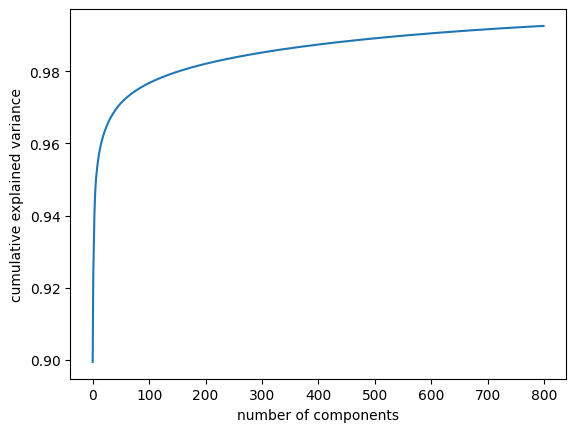

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 792,principal component 793,principal component 794,principal component 795,principal component 796,principal component 797,principal component 798,principal component 799,principal component 800,label
0,-4.672447,-1.896179,-0.857361,0.760460,0.223134,0.540348,0.138052,0.003247,0.367371,0.799784,...,0.024820,-0.017938,-0.069529,-0.008077,0.011602,-0.002820,-0.018718,0.008401,0.016212,0
1,6.144248,-2.503179,1.582872,1.220579,-0.257928,-2.081524,-0.306540,-0.018640,-0.326360,-0.548695,...,-0.009813,-0.016132,-0.026055,-0.066850,-0.002197,-0.068730,0.037570,-0.008488,0.011072,1
2,-6.390308,0.402832,-0.605718,0.480925,-0.141508,-0.134694,-1.003577,0.173118,-0.378646,0.142021,...,0.006375,0.009492,0.000544,0.002621,-0.011478,0.013507,-0.013998,0.033301,0.021105,1
3,-2.089294,-1.097952,-0.752888,0.592145,-0.925858,-1.585935,-0.303151,0.581166,-0.691150,0.263477,...,-0.021622,0.048427,0.064351,0.064692,-0.016444,0.035662,0.021131,0.060063,-0.006909,1
4,-15.781447,-0.005864,1.092689,0.982710,0.576955,0.164995,-0.165220,0.380575,-0.377653,-0.069072,...,-0.030736,-0.013618,-0.025725,-0.001430,0.023536,-0.005958,-0.016007,-0.001751,-0.012257,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-12.716052,-0.672033,0.439630,-0.029638,0.208735,-0.561087,0.408959,-0.234635,0.381868,0.156590,...,-0.021458,-0.006788,-0.057586,0.009612,0.011504,-0.026544,0.004492,0.052510,-0.017940,1
19996,1.917144,-0.191820,0.204096,-1.099354,0.130028,0.437420,-0.338680,-0.932536,-0.899290,-0.074484,...,-0.122816,-0.033245,0.046239,0.051406,-0.013844,-0.026956,0.024215,-0.088440,-0.043863,1
19997,-14.199579,-0.404867,0.694590,-0.155676,-0.854879,-0.514763,-0.030922,-0.357027,-0.850320,0.203425,...,-0.003423,-0.012044,0.006051,-0.003665,0.014729,-0.002339,-0.012126,0.039750,0.019480,0
19998,-0.572852,-0.973120,1.095301,-0.251007,-0.159457,-0.130642,-0.519507,-0.186826,-0.622680,-0.054179,...,0.000370,0.008426,0.017052,0.027590,-0.044032,-0.018287,0.003063,0.011264,-0.019037,0


In [125]:
# Do PCA analysis to see if we can reduce the number of features:
N = 800
pca = PCA(n_components=N)
principalComponents = pca.fit_transform(traintest_df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component ' + str(i) for i in range(1, N+1)])

#plot the explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

#Prepare the dataset as a dataframe for the model with preds
principalDf = pd.concat([principalDf, train_labels["label"]], axis=1)
principalDf



In [134]:
# Try using featureselection to reduce the number of features:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFpr
from sklearn.feature_selection import SelectFdr

#apply SelectKBest class to extract top 500 best features:
K = 200
bestfeatures = SelectKBest(score_func=chi2, k=K)

fit = bestfeatures.fit(traintest_df, train_labels["label"])


dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(traintest_df.columns)

#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

print(featureScores.nlargest(K,'Score'))  #print 500 best features

#make a list of the 500 best features
list_of_500_best_features = featureScores.nlargest(K,'Score')["Specs"].tolist()

#make a dataframe with only the 500 best features
traintest_df_500 = traintest_df[list_of_500_best_features]

#also make validation_df_500:
validation_df_500 = validation_df[list_of_500_best_features]
#add labels:
traintest_df_500 = pd.concat([traintest_df_500, train_labels["label"]], axis=1)


            Specs       Score
30   0.6371788217  453.746112
1    0.6223807245  442.933262
78   0.6513124137  430.582800
22   0.6335286032  424.206245
60   0.6492627054  423.592043
..            ...         ...
321  0.6664363848  330.387196
398  0.6703830405  330.300180
351  0.6677664204  330.248736
291  0.6650874454  330.126639
300  0.6656178113  329.966587

[200 rows x 2 columns]


# Do the model training:

In [135]:
# define the input model data from the preprocessing:
# Current dataset verisons:
traintest_df_subset0 = traintest_df
traintest_df_subset1 = principalDf
traintest_df_subset2 = traintest_df_500

#------------------------------------------------------------------------------------------------
# 
X, y  = traintest_df_subset2.drop("label", axis=1), traintest_df_subset2["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [136]:
"""
alpha	0.19940462245879345
colsample_bylevel	0.6082032831689801
colsample_bytree	0.5026761553080533
custom_metric	None
early_stopping_rounds	50
eta	0.01834603996998217
eval_metric	['error', 'auc', 'logloss']
gamma	0.01897331639253623
lambda	0.14867997340472994
max_depth	5
maximize	None
min_child_weight	0.5347175461839557
num_boost_round	1000
objective	binary:logistic
"""
#set params from above:
params_from_hyperopt2 = {
    'alpha': 0.19940462245879345,
    'colsample_bylevel': 0.6082032831689801,
    'colsample_bytree': 0.5026761553080533,
    'early_stopping_rounds': 50,
    'eta': 0.01834603996998217,
    'gamma': 0.01897331639253623,
    'lambda': 0.14867997340472994,
    'max_depth': 5,
    'min_child_weight': 0.5347175461839557,
    'num_boost_round': 1000,
    'objective': 'binary:logistic'
    }

#set params from above:
params_from_hyperopt = {
    'objective': 'binary:logistic',
    'eval_metric': ['error', 'auc', 'logloss'],
    'eta': 0.09021011892819718,
    'max_depth': 6,
    'min_child_weight': 0.7776461453397946,
    'subsample': 0.7649830775674538,
    'colsample_bytree': 0.4806978784720332,
    'colsample_bylevel': 0.8876867721023922,
    'alpha': 0.0918962468520413,
    'lambda': 0.4786418563322011,
    'gamma': 0.0038307274657378857,
    'seed': 41
}

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 7,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'min_child_weight': 1.2,
    #set small alpha:
    'alpha': 0.01,
    'lambda': 1,
    'seed': 42
}

print(X_train.shape, "X_train shape")
print(X_test.shape, "X_test shape")
dtrain = xgb.DMatrix(X_train, label=y_train )
dtest = xgb.DMatrix(X_test, label=y_test)
print(y_train.shape)
print(y_test.shape)


(16000, 200) X_train shape
(4000, 200) X_test shape
(16000,)
(4000,)


In [137]:
# print output for each 50th iteration:
watchlist = [(dtrain, 'train'), (dtest, 'test')]

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("subset_models")
with mlflow.start_run():
    evals_result = {}
    model = xgb.train(params_from_hyperopt, dtrain, num_boost_round=1000, evals=watchlist,evals_result = evals_result, verbose_eval=5, early_stopping_rounds=50)
    y_pred = model.predict(dtest)

[0]	train-error:0.26594	train-auc:0.81679	train-logloss:0.66649	test-error:0.27900	test-auc:0.79547	test-logloss:0.66843
[5]	train-error:0.25862	train-auc:0.83535	train-logloss:0.58096	test-error:0.27725	test-auc:0.80784	test-logloss:0.59221
[10]	train-error:0.25581	train-auc:0.83910	train-logloss:0.53782	test-error:0.27600	test-auc:0.80848	test-logloss:0.55733
[15]	train-error:0.25338	train-auc:0.84270	train-logloss:0.51249	test-error:0.27750	test-auc:0.80990	test-logloss:0.53894
[20]	train-error:0.25125	train-auc:0.84661	train-logloss:0.49605	test-error:0.27425	test-auc:0.81157	test-logloss:0.52879
[25]	train-error:0.24863	train-auc:0.84989	train-logloss:0.48478	test-error:0.27175	test-auc:0.81256	test-logloss:0.52358
[30]	train-error:0.24513	train-auc:0.85415	train-logloss:0.47619	test-error:0.27275	test-auc:0.81252	test-logloss:0.52132
[35]	train-error:0.24263	train-auc:0.85707	train-logloss:0.47008	test-error:0.27425	test-auc:0.81200	test-logloss:0.52053
[40]	train-error:0.24044	t

In [33]:
# calculate accuracy using round:
y_pred_round = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_round)


logloss = log_loss(y_test, y_pred)

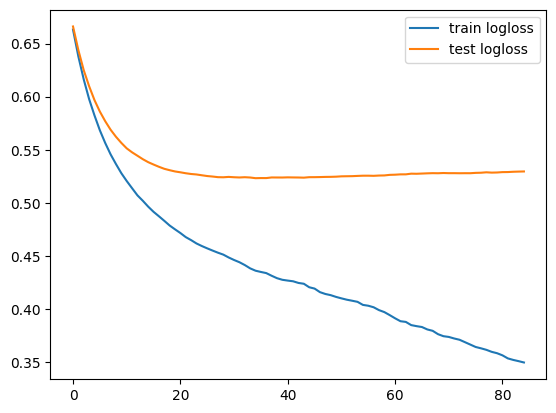

In [34]:

# plot logloss over time for train and test sets:
plt.plot(evals_result['train']['logloss'], label='train logloss')
plt.plot(evals_result['test']['logloss'], label='test logloss')


plt.legend()
plt.show()



In [35]:

best_iteration = model.best_iteration
print(best_iteration)





34


In [36]:
#Prep the submission format:
validation_df["pred"]= model.predict(xgb.DMatrix(test_df), ntree_limit=best_iteration)
validation_df["id"] = validation_df.index

#save to file:
validation_df[["id", "pred"]].to_csv("results/submission.csv", index=False)

/Users/m98612/venv/fradrag2021/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/9_/syprsqwd263_tvl61_yf9pwm0000gn/T/ipykernel_63042/1632241534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["pred"]= model.predict(xgb.DMatrix(test_df), ntree_limit=best_iteration)
/var/folders/9_/syprsqwd263_tvl61_yf9pwm0000gn/T/ipykernel_63042/1632241534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

# Test of Hyperopt

AttributeError: 'randint_gen' object has no attribute 'pdf'

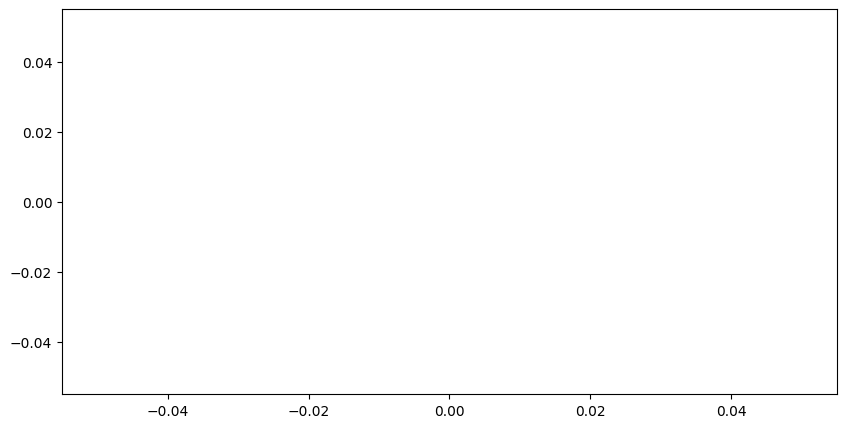

In [141]:

search_space = {
    "objective": "binary:logistic",  # objective
    "eta": hp.loguniform("learning_rate", -4, -1.2),  # learning rate
    "min_child_weight": hp.loguniform(
        "min_child_weight", -1, 3
    ),  # minimum sum of weights of all observations required in child.
    "max_depth": scope.int(hp.quniform("max_depth", 4, 20, 1)),
    "subsample": hp.loguniform(
        "subsample", -0.91, 0
    ),  # fraction of observations to be randomly samples for each tree.
    "colsample_bytree": hp.loguniform(
        "colsample_bytree", -0.91, 0
    ),  # fraction of columns to be randomly sampled for each tree.
    "colsample_bylevel": hp.loguniform(
        "colsample_bylevel", -0.91, 0
    ),  # subsample ratio of columns for each split, in each level.
    "lambda": hp.loguniform(
        "lambda", -4, 0
    ),  # L2 regularization term on weights (Ridge)
    "alpha": hp.loguniform(
        "alpha", -4, -1.2
    ),  # L1 regularization term on weight (Lasso)
    "gamma": hp.loguniform(
        "gamma", -6, 2.7
    ),  # minimum loss reduction required to make a split
    "seed": 41,
}


def objective(search_space):
    """
    Encapsulated objective-function such that hyperopt function can reach input-data in objective function
    """
    dtrain = xgb.DMatrix(X_train.copy(), label=y_train)
    dtest = xgb.DMatrix(X_test.copy(), label=y_test)

    watchlist = [(dtrain, 'train'), (dtest, 'test')]
    verbose_eval = 50
    with mlflow.start_run(nested=True):
        search_space["eval_metric"] = ["error", "auc", "logloss"]
        num_round = 1000
        evals_result = {}
        num_features = 80
        bst = xgb.train(
            search_space,
            dtrain,
            num_round,
            evals=watchlist,
            evals_result=evals_result,
            early_stopping_rounds=50,
            verbose_eval=verbose_eval,
        )
        print(f"Stopping after {len(evals_result['train']['error'])} rounds")


        min_logloss_error= np.min(evals_result["test"]["logloss"])
        mlflow.xgboost.log_model(bst, artifact_path="model")

        #use cross validation to get the best iteration:
        # cv_results = xgb.cv(
        #    search_space,
        #   dtrain,
        #   num_boost_round=num_round,
        #  nfold=5,
        # early_stopping_rounds=50,
        # verbose_eval=verbose_eval,
        # show_stdv=False,
        # )
        # print(cv_results)
        # min_logloss_error = cv_results["test-logloss-mean"].min()
        # print(f"Best logloss: {min_logloss_error}")
        # best_iteration = cv_results["test-logloss-mean"].idxmin()
        # print(f"Best iteration: {best_iteration}")
        # mlflow.log_metric("best_iteration", best_iteration)
        # mlflow.log_metric("best_logloss", min_logloss_error)
        #  

        return {
            "status": STATUS_OK,
            "loss": min_logloss_error,
            "booster": bst.attributes(),
        }



In [38]:
#
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.xgboost.autolog(
    log_input_examples=False, log_model_signatures=True, log_models=True
)


2022/11/04 12:15:33 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


In [138]:

mlflow.set_experiment("hyperopt_test_4_subset")

mlflow.xgboost.autolog(
    log_input_examples=False, log_model_signatures=True, log_models=True
)


with mlflow.start_run(run_name="test"):
    best_params = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=100,
    )


2022/11/04 15:47:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


[0]	train-error:0.21619	train-auc:0.84977	train-logloss:0.59592	test-error:0.33225	test-auc:0.73329	test-logloss:0.64177
[50]	train-error:0.00200	train-auc:0.99996	train-logloss:0.09986	test-error:0.29700	test-auc:0.77997	test-logloss:0.63386
[55]	train-error:0.00131	train-auc:0.99998	train-logloss:0.09359	test-error:0.29450	test-auc:0.78053	test-logloss:0.63746
Stopping after 57 rounds                               
[0]	train-error:0.26856	train-auc:0.81967	train-logloss:0.66021	test-error:0.29150	test-auc:0.79717	test-logloss:0.66282
[50]	train-error:0.21756	train-auc:0.88656	train-logloss:0.43283	test-error:0.27300	test-auc:0.81144	test-logloss:0.51965
[81]	train-error:0.16881	train-auc:0.93071	train-logloss:0.38166	test-error:0.27550	test-auc:0.80881	test-logloss:0.52451
Stopping after 82 rounds                                                         
[0]	train-error:0.26044	train-auc:0.82826	train-logloss:0.60449	test-error:0.33250	test-auc:0.75076	test-logloss:0.63170
[50]	train-

KeyboardInterrupt: 

In [92]:

!ls

data                          sample_submissions.csv
eda.ipynb                     simple_blending_example.ipynb
mlruns                        submission_files
results                       train_labels.csv


# Make predictions:

In [105]:

#current best model:
# Load model as a PyFuncModel.
#path to local model:
logged_model2 = "mlruns/6/cd1d6d5f985044c58327ff5a92d0510d/artifacts/model"


#loaded_model1 = mlflow.xgboost.load_model(logged_model1)
loaded_model2 = mlflow.xgboost.load_model(logged_model2)
loaded_model3 = mlflow.pyfunc.load_model(logged_model2)


In [106]:
print(loaded_model2)
print(loaded_model3)

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.xgboost
  run_id: cd1d6d5f985044c58327ff5a92d0510d



In [107]:
#traintest_df.drop("label")
traintest_df = traintest_df.drop('label',axis=1)

KeyError: "['label'] not found in axis"

In [108]:
#Validate model on the validation_df_500 

validation_df_500 = validation_df[list_of_500_best_features]
#Prep the submission format:
validation_df_500["pred"]= loaded_model3.predict(validation_df_500)
validation_df_500["id"] = validation_df.index

#save to file:
validation_df_500[["id", "pred"]].to_csv("results/submission_hyperopt_best500_preprocess2.csv", index=False)

